# Denoising Challenge

In [1]:
import  torch
torch.__version__

'0.4.0'

### Importing & prepare data

In [2]:
import numpy as np

with np.load('./data/denoising-challenge-01-data.npz') as fh:
        train_y = fh['training_images_clean']
        validation_x = fh['validation_images_noisy']
        validation_y = fh['validation_images_clean']
        test_x = fh['test_images_noisy']

### Data shapes

In [3]:
print('training: ' + str(train_y.shape))
print('validation: ' + str(validation_x.shape))
print('test: ' + str(test_x.shape))

training: (20000, 1, 28, 28)
validation: (2000, 1, 28, 28)
test: (2000, 1, 28, 28)


### Visualize some data

(1, 28, 28)


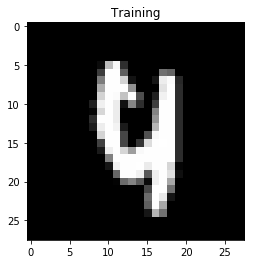

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title('Training')
print(train_y[0].shape)
plt.imshow(train_y[0].reshape(28,28), cmap='gray')

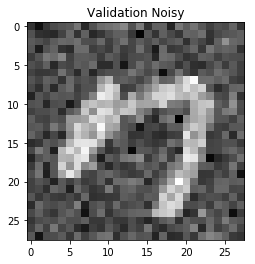

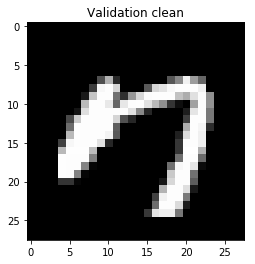

In [5]:
plt.figure()
plt.title('Validation Noisy')
plt.imshow(validation_x[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

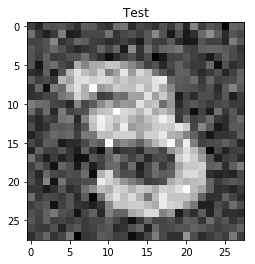

In [6]:
plt.figure()
plt.title('Test')
plt.imshow(test_x[0].reshape(28,28), cmap='gray')

### Calculate standart deviation of gaussian noise

In [7]:
noise = validation_x - validation_y
noise_sigma = np.std(noise)

noise_sigma

0.20003203

### Create a noise generator

In [8]:
def getNoisy(clean, sigma=noise_sigma):
    return clean + sigma * np.random.normal(0, 1, clean.shape)

### Check if we get everything right by adding noise to validation image and displaying it

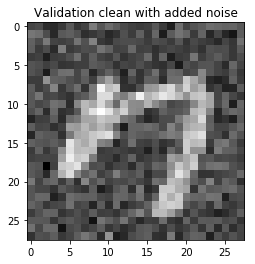

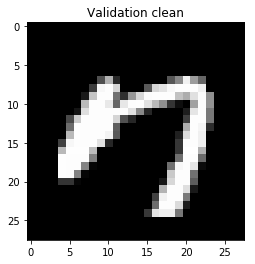

In [9]:
plt.figure()
plt.title('Validation clean with added noise')
plt.imshow(getNoisy(validation_y[0]).reshape(28, 28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

### Data Augmentation (Bootstrapping)

We don't really want to predict anything so we can go wild and crazy with the transformations (horizontal & vertical flips, random rotations, etc.). As we don't have much computing power however, we will only use flips, as they are pretty fast to compute.

In [10]:
def horizontalFlip(image):
    return np.flip(image, 3)

def verticalFlip(image):
    return np.flip(image, 2)

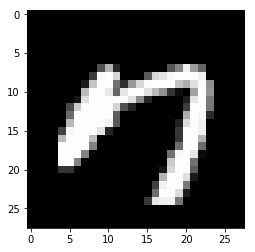

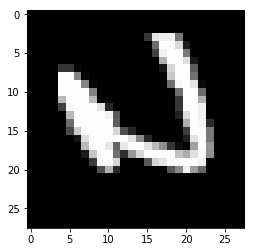

In [11]:
plt.figure("some image")
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

plt.figure("some vertically flipped image")
plt.imshow(verticalFlip(validation_y)[0].reshape(28,28), cmap='gray')

In [12]:
def get_train_x(train_y):
    # with 20% probability, flip in each direction
    flip_x = np.where(np.random.binomial(1, 0.2, size=len(train_y)) == 1)[0]
    flip_y = np.where(np.random.binomial(1, 0.2, size=len(train_y)) == 1)[0]
    train_x = getNoisy(train_y)
    train_x[flip_x] = horizontalFlip(train_x[flip_x])
    train_x[flip_y] = horizontalFlip(train_x[flip_y])
    
    return train_x

### Prepare data for training

In [13]:
import torch.utils.data as data_utils

kwargs  =  {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}

train_dataset = data_utils.TensorDataset(torch.from_numpy(train_y), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

torch.Size([128, 1, 28, 28])


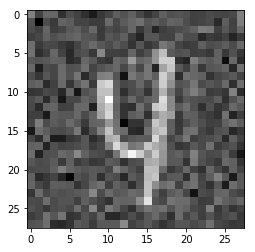

In [14]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    augmented_data = torch.from_numpy(get_train_x(data.numpy()))
    plt.imshow(augmented_data[0].reshape(28,28), cmap="gray")
    break

## Model

We based our model entirely on residual denoising convolutional NN. Further information can be found in this paper (https://arxiv.org/pdf/1608.03981.pdf). 

In [15]:
import torch.nn as nn
import torch.nn.functional as F

NUM_TYPE_2_LAYERS = 6

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layers = self._make_layers()

    def forward(self, x):
        return self.layers(x)
    
    def _make_layers(self):
        conv_layers = []
        
        conv_layers += [
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            # NOTE: no BN here
            nn.ReLU(inplace=True)
        ]
        for i in range(NUM_TYPE_2_LAYERS):
            conv = nn.Conv2d(32, 32, kernel_size=3, padding=1)
            conv_layers += [conv,
                           nn.BatchNorm2d(32),
                           nn.ReLU(inplace=True)]
            
        conv_layers += [
            # NOTE: only one filter is produced here, the residual image
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            # NOTE: no BN here
            nn.ReLU(inplace=True)
        ]
            
        return nn.Sequential(*conv_layers)

In [16]:
model = VGG().double()
if torch.cuda.is_available():
    model.cuda()

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
def forbenius_norm(output, target):
    return np.mean(np.sqrt(np.sum((output - target)**2, axis=(1,2,3))))

In [19]:
from torch.autograd import Variable

def train(epoch, callback):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        augmented_data = torch.from_numpy(get_train_x(data.numpy()))
        data, target = Variable(augmented_data), Variable(target)

        optimizer.zero_grad()
        output_residual = model(data)
        target_residual = data - target.double()
        
        residual_loss = F.mse_loss(output_residual, target_residual)
        residual_loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output_residual, target, data)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), residual_loss.item()))

In [20]:
def test():
    model.eval()
    
    test_loss = 0
    forbenius_losses = []
    for data, target in validation_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        output_residual = model(data.double())
        target_residual = data.double() - target.double()
        # sum up batch loss
        test_loss += F.mse_loss(output_residual, target_residual, size_average=False).item()
        
        forbenius_losses.append(
            forbenius_norm((data.double() - output_residual).detach().numpy(), target.numpy()))
        
    forbenius_loss = np.array(forbenius_losses).mean()

    test_loss /= len(validation_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Forbenius\' norm: {}\n'.format(
        test_loss, forbenius_loss))
    
    return forbenius_loss, test_loss

### Some plotting helper functions

In [21]:
def save_accuracy(i, output_residual, target, input_data, save_in):
    forbenius = forbenius_norm((input_data - output_residual).detach().numpy(), target.detach().numpy())
    save_in.append(forbenius)
    
def get_save_acc_in(save_in):
    return lambda x, y, z, v: save_accuracy(x, y, z, v, save_in)

In [22]:
%%time

per_batch_forbenius = []
epoch_forbenius = []
val_losses = []
best_loss = None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# max 200 epochs, we are going to stop training when validation score gets worse
for epoch in range(1, 15 + 1):
    train(epoch, get_save_acc_in(per_batch_forbenius))
    forbenius, val_loss = test()
    epoch_forbenius.append(forbenius)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if best_loss is None or best_loss > val_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model')

Train Epoch: 1 [128/20000 (1%)]	Loss: 0.103278
Train Epoch: 1 [256/20000 (1%)]	Loss: 0.103205
Train Epoch: 1 [384/20000 (2%)]	Loss: 0.090984
Train Epoch: 1 [512/20000 (3%)]	Loss: 0.088942
Train Epoch: 1 [640/20000 (3%)]	Loss: 0.091249
Train Epoch: 1 [768/20000 (4%)]	Loss: 0.082052
Train Epoch: 1 [896/20000 (4%)]	Loss: 0.080620
Train Epoch: 1 [1024/20000 (5%)]	Loss: 0.073804
Train Epoch: 1 [1152/20000 (6%)]	Loss: 0.085574
Train Epoch: 1 [1280/20000 (6%)]	Loss: 0.070052
Train Epoch: 1 [1408/20000 (7%)]	Loss: 0.082527
Train Epoch: 1 [1536/20000 (8%)]	Loss: 0.080402
Train Epoch: 1 [1664/20000 (8%)]	Loss: 0.075755
Train Epoch: 1 [1792/20000 (9%)]	Loss: 0.077121
Train Epoch: 1 [1920/20000 (10%)]	Loss: 0.077612
Train Epoch: 1 [2048/20000 (10%)]	Loss: 0.067317
Train Epoch: 1 [2176/20000 (11%)]	Loss: 0.069686
Train Epoch: 1 [2304/20000 (11%)]	Loss: 0.065748
Train Epoch: 1 [2432/20000 (12%)]	Loss: 0.073225
Train Epoch: 1 [2560/20000 (13%)]	Loss: 0.072523
Train Epoch: 1 [2688/20000 (13%)]	Loss: 0

Train Epoch: 2 [1152/20000 (6%)]	Loss: 0.052178
Train Epoch: 2 [1280/20000 (6%)]	Loss: 0.055895
Train Epoch: 2 [1408/20000 (7%)]	Loss: 0.056540
Train Epoch: 2 [1536/20000 (8%)]	Loss: 0.057577
Train Epoch: 2 [1664/20000 (8%)]	Loss: 0.059228
Train Epoch: 2 [1792/20000 (9%)]	Loss: 0.056631
Train Epoch: 2 [1920/20000 (10%)]	Loss: 0.061276
Train Epoch: 2 [2048/20000 (10%)]	Loss: 0.054017
Train Epoch: 2 [2176/20000 (11%)]	Loss: 0.056285
Train Epoch: 2 [2304/20000 (11%)]	Loss: 0.048672
Train Epoch: 2 [2432/20000 (12%)]	Loss: 0.057650
Train Epoch: 2 [2560/20000 (13%)]	Loss: 0.051716
Train Epoch: 2 [2688/20000 (13%)]	Loss: 0.056699
Train Epoch: 2 [2816/20000 (14%)]	Loss: 0.052644
Train Epoch: 2 [2944/20000 (15%)]	Loss: 0.056753
Train Epoch: 2 [3072/20000 (15%)]	Loss: 0.059344
Train Epoch: 2 [3200/20000 (16%)]	Loss: 0.056497
Train Epoch: 2 [3328/20000 (17%)]	Loss: 0.050384
Train Epoch: 2 [3456/20000 (17%)]	Loss: 0.059714
Train Epoch: 2 [3584/20000 (18%)]	Loss: 0.059160
Train Epoch: 2 [3712/20000

Train Epoch: 3 [2176/20000 (11%)]	Loss: 0.057366
Train Epoch: 3 [2304/20000 (11%)]	Loss: 0.057960
Train Epoch: 3 [2432/20000 (12%)]	Loss: 0.059180
Train Epoch: 3 [2560/20000 (13%)]	Loss: 0.051161
Train Epoch: 3 [2688/20000 (13%)]	Loss: 0.049356
Train Epoch: 3 [2816/20000 (14%)]	Loss: 0.051845
Train Epoch: 3 [2944/20000 (15%)]	Loss: 0.050433
Train Epoch: 3 [3072/20000 (15%)]	Loss: 0.056288
Train Epoch: 3 [3200/20000 (16%)]	Loss: 0.051617
Train Epoch: 3 [3328/20000 (17%)]	Loss: 0.051244
Train Epoch: 3 [3456/20000 (17%)]	Loss: 0.044025
Train Epoch: 3 [3584/20000 (18%)]	Loss: 0.055549
Train Epoch: 3 [3712/20000 (18%)]	Loss: 0.052507
Train Epoch: 3 [3840/20000 (19%)]	Loss: 0.056860
Train Epoch: 3 [3968/20000 (20%)]	Loss: 0.048316
Train Epoch: 3 [4096/20000 (20%)]	Loss: 0.051852
Train Epoch: 3 [4224/20000 (21%)]	Loss: 0.054750
Train Epoch: 3 [4352/20000 (22%)]	Loss: 0.050172
Train Epoch: 3 [4480/20000 (22%)]	Loss: 0.042630
Train Epoch: 3 [4608/20000 (23%)]	Loss: 0.052442
Train Epoch: 3 [4736

Train Epoch: 4 [3200/20000 (16%)]	Loss: 0.047373
Train Epoch: 4 [3328/20000 (17%)]	Loss: 0.050782
Train Epoch: 4 [3456/20000 (17%)]	Loss: 0.054253
Train Epoch: 4 [3584/20000 (18%)]	Loss: 0.052274
Train Epoch: 4 [3712/20000 (18%)]	Loss: 0.053141
Train Epoch: 4 [3840/20000 (19%)]	Loss: 0.050396
Train Epoch: 4 [3968/20000 (20%)]	Loss: 0.053973
Train Epoch: 4 [4096/20000 (20%)]	Loss: 0.049896
Train Epoch: 4 [4224/20000 (21%)]	Loss: 0.052868
Train Epoch: 4 [4352/20000 (22%)]	Loss: 0.055605
Train Epoch: 4 [4480/20000 (22%)]	Loss: 0.044183
Train Epoch: 4 [4608/20000 (23%)]	Loss: 0.049744
Train Epoch: 4 [4736/20000 (24%)]	Loss: 0.045578
Train Epoch: 4 [4864/20000 (24%)]	Loss: 0.045337
Train Epoch: 4 [4992/20000 (25%)]	Loss: 0.053822
Train Epoch: 4 [5120/20000 (25%)]	Loss: 0.052320
Train Epoch: 4 [5248/20000 (26%)]	Loss: 0.057054
Train Epoch: 4 [5376/20000 (27%)]	Loss: 0.048134
Train Epoch: 4 [5504/20000 (27%)]	Loss: 0.055954
Train Epoch: 4 [5632/20000 (28%)]	Loss: 0.050295
Train Epoch: 4 [5760

Train Epoch: 5 [4224/20000 (21%)]	Loss: 0.049258
Train Epoch: 5 [4352/20000 (22%)]	Loss: 0.053050
Train Epoch: 5 [4480/20000 (22%)]	Loss: 0.046390
Train Epoch: 5 [4608/20000 (23%)]	Loss: 0.050611
Train Epoch: 5 [4736/20000 (24%)]	Loss: 0.050753
Train Epoch: 5 [4864/20000 (24%)]	Loss: 0.060686
Train Epoch: 5 [4992/20000 (25%)]	Loss: 0.059201
Train Epoch: 5 [5120/20000 (25%)]	Loss: 0.051507
Train Epoch: 5 [5248/20000 (26%)]	Loss: 0.055059
Train Epoch: 5 [5376/20000 (27%)]	Loss: 0.052212
Train Epoch: 5 [5504/20000 (27%)]	Loss: 0.049498
Train Epoch: 5 [5632/20000 (28%)]	Loss: 0.050635
Train Epoch: 5 [5760/20000 (29%)]	Loss: 0.047795
Train Epoch: 5 [5888/20000 (29%)]	Loss: 0.049211
Train Epoch: 5 [6016/20000 (30%)]	Loss: 0.050530
Train Epoch: 5 [6144/20000 (31%)]	Loss: 0.052502
Train Epoch: 5 [6272/20000 (31%)]	Loss: 0.050330
Train Epoch: 5 [6400/20000 (32%)]	Loss: 0.051855
Train Epoch: 5 [6528/20000 (32%)]	Loss: 0.050812
Train Epoch: 5 [6656/20000 (33%)]	Loss: 0.050362
Train Epoch: 5 [6784

Train Epoch: 6 [5248/20000 (26%)]	Loss: 0.055803
Train Epoch: 6 [5376/20000 (27%)]	Loss: 0.052585
Train Epoch: 6 [5504/20000 (27%)]	Loss: 0.047469
Train Epoch: 6 [5632/20000 (28%)]	Loss: 0.045106
Train Epoch: 6 [5760/20000 (29%)]	Loss: 0.052628
Train Epoch: 6 [5888/20000 (29%)]	Loss: 0.049160
Train Epoch: 6 [6016/20000 (30%)]	Loss: 0.048606
Train Epoch: 6 [6144/20000 (31%)]	Loss: 0.053568
Train Epoch: 6 [6272/20000 (31%)]	Loss: 0.048350
Train Epoch: 6 [6400/20000 (32%)]	Loss: 0.050686
Train Epoch: 6 [6528/20000 (32%)]	Loss: 0.048568
Train Epoch: 6 [6656/20000 (33%)]	Loss: 0.046777
Train Epoch: 6 [6784/20000 (34%)]	Loss: 0.050642
Train Epoch: 6 [6912/20000 (34%)]	Loss: 0.050792
Train Epoch: 6 [7040/20000 (35%)]	Loss: 0.051527
Train Epoch: 6 [7168/20000 (36%)]	Loss: 0.052129
Train Epoch: 6 [7296/20000 (36%)]	Loss: 0.044750
Train Epoch: 6 [7424/20000 (37%)]	Loss: 0.048337
Train Epoch: 6 [7552/20000 (38%)]	Loss: 0.052005
Train Epoch: 6 [7680/20000 (38%)]	Loss: 0.055800
Train Epoch: 6 [7808

Train Epoch: 7 [6272/20000 (31%)]	Loss: 0.052167
Train Epoch: 7 [6400/20000 (32%)]	Loss: 0.055203
Train Epoch: 7 [6528/20000 (32%)]	Loss: 0.057681
Train Epoch: 7 [6656/20000 (33%)]	Loss: 0.059818
Train Epoch: 7 [6784/20000 (34%)]	Loss: 0.049979
Train Epoch: 7 [6912/20000 (34%)]	Loss: 0.050355
Train Epoch: 7 [7040/20000 (35%)]	Loss: 0.051604
Train Epoch: 7 [7168/20000 (36%)]	Loss: 0.051454
Train Epoch: 7 [7296/20000 (36%)]	Loss: 0.055271
Train Epoch: 7 [7424/20000 (37%)]	Loss: 0.053800
Train Epoch: 7 [7552/20000 (38%)]	Loss: 0.049805
Train Epoch: 7 [7680/20000 (38%)]	Loss: 0.051615
Train Epoch: 7 [7808/20000 (39%)]	Loss: 0.050145
Train Epoch: 7 [7936/20000 (39%)]	Loss: 0.051590
Train Epoch: 7 [8064/20000 (40%)]	Loss: 0.046736
Train Epoch: 7 [8192/20000 (41%)]	Loss: 0.057912
Train Epoch: 7 [8320/20000 (41%)]	Loss: 0.048660
Train Epoch: 7 [8448/20000 (42%)]	Loss: 0.054800
Train Epoch: 7 [8576/20000 (43%)]	Loss: 0.049893
Train Epoch: 7 [8704/20000 (43%)]	Loss: 0.051670
Train Epoch: 7 [8832

Process Process-63:
Process Process-61:
Process Process-62:
Process Process-64:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hristov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hristov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/hristov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hristov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hristov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/hristov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hristov/anaconda3/lib/python3.6/site

KeyboardInterrupt: 

### Prediction

In [23]:
def predict(data):
    output_residual = model(Variable(torch.from_numpy(data)).double())
    return data - output_residual.detach()

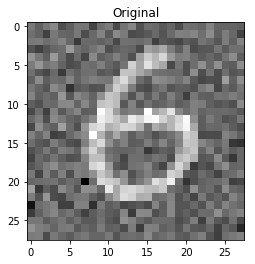

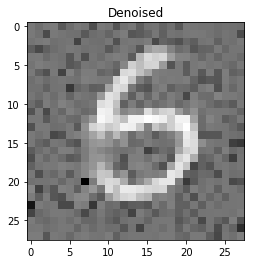

In [24]:
prediction = predict(test_x[0:5])

plt.figure()
plt.title("Original")
plt.imshow(test_x[1][0], cmap='gray')

plt.figure()
plt.title("Denoised")
plt.imshow(prediction[1][0], cmap='gray')

In [25]:
def plot_accuracy(accuracy_arr, title, xlabel='Number of batches seen'):
    ax = plt.gca()
    ax.plot(np.arange(len(accuracy_arr)), accuracy_arr)
    # could be more than the total number of batches because of epochs
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Forbenius')
    ax.set_xticks(np.arange(len(accuracy_arr)))
    plt.title(title)
    plt.show()
    np.arange(len(accuracy_arr))

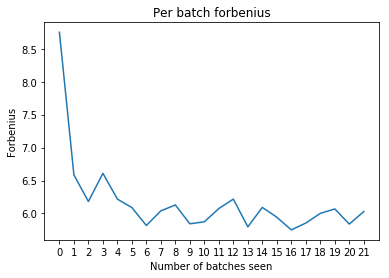

In [26]:
plot_accuracy(per_batch_forbenius[::50], 'Per batch forbenius')

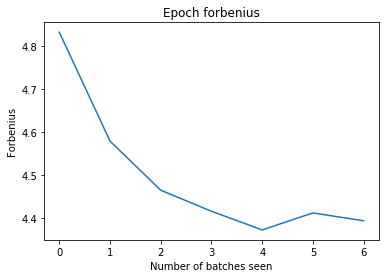

In [27]:
plot_accuracy(epoch_forbenius, 'Epoch forbenius')

In [28]:
model = VGG().double()
model.load_state_dict(torch.load('./model'))

In [ ]:
test()


Test set: Average loss: 19.1746, Forbenius' norm: 4.372854504754168



(4.3728545047541676, 19.174594682485544)

In [ ]:
test_images_clean = predict(test_x).data.numpy()

assert test_images_clean.ndim == 4
assert test_images_clean.shape[0] == 2000
assert test_images_clean.shape[1] == 1
assert test_images_clean.shape[2] == 28
assert test_images_clean.shape[3] == 28

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('test_images_clean.npy', test_images_clean)